In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented_dataset.csv


In [2]:
import pandas as pd

In [3]:
# let's store the csv dataset into a DataFrame and have a look at it
# Ссылка на скачивание данных в формате CSV
csv_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT3Wns_gLiMDfacVgF-x4suNvnAFmgibVkrsizkKqwcVFGSYAVOVnJsoV7gm3jguw/pub?gid=681978523&single=true&output=csv"

# Загрузка данных в DataFrame
data = pd.read_csv(csv_data_url)

# Просмотр первых нескольких строк данных
print(data.head())

   Unnamed: 0                                       problem_text  \
0           0  To prove that the sum of the numbers of the ex...   
1           1  ( b) Will the statement of the previous challe...   
2           2  The quadratic three-member graph with the coef...   
3           3  Can you draw on the surface of Rubik's cube a ...   
4           4  Dima, who came from Vrunlandia, said that ther...   

           topic  
0  number_theory  
1  number_theory  
2       polynoms  
3  combinatorics  
4         graphs  


In [4]:
# Lets count duplicated entries in the problem_text column
# 'problem_text' имя столбца, в котором нужно найти дубликаты
duplicates = data.duplicated(subset=['problem_text'], keep=False)

# Считаем количество дубликатов
num_duplicates = duplicates.sum()

# Выводим количество дубликатов
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')


Количество дубликатов в столбце "problem_text": 1720


In [5]:
# We'll leave the first entries and we'll drop the duplicates 
# Удаляем дубликаты, оставляя только первые вхождения
data_no_dupes = data.drop_duplicates(subset=['problem_text'], keep='first')

# Перезаписываем индексы после удаления дубликатов
data_no_dupes.reset_index(drop=True, inplace=True)


In [6]:
# We need to check the results. We expect 0 duplicated entries in the column we cleaned
#смотрим, как удалили 
duplicates = data_no_dupes.duplicated(subset=['problem_text'], keep=False)
num_duplicates = duplicates.sum()
print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 0


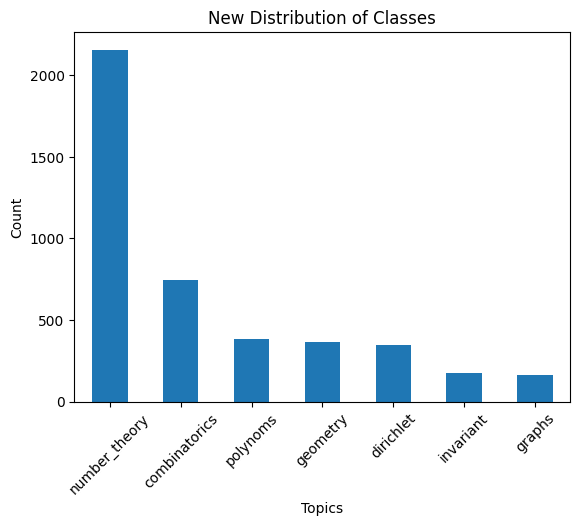

In [7]:
# A quick visual aid to check the distribution over classes
# распределение по классам
import matplotlib.pyplot as plt

class_counts = data_no_dupes['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [8]:
class_counts

topic
number_theory    2156
combinatorics     743
polynoms          380
geometry          364
dirichlet         344
invariant         172
graphs            160
Name: count, dtype: int64

In [9]:
# We'll need to augment the datset to balance the distribution 
# but beforehand we should split the data set into test train val sets 
#разобьем на test train val
from sklearn.model_selection import train_test_split

# Разделение датасета
train, test_val = train_test_split(data_no_dupes, test_size=0.4, random_state=42)
val, test = train_test_split(test_val, test_size=0.5, random_state=42)

# сохраним
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)


In [10]:
!ls -la /kaggle/working

total 434160
drwxr-xr-x 6 root root      4096 May  5 22:16 .
drwxr-xr-x 5 root root      4096 May  5 22:16 ..
drwxr-xr-x 2 root root      4096 May  5 22:16 .virtual_documents
drwxr-xr-x 2 root root      4096 May  5 22:15 logs
drwxr-xr-x 9 root root      4096 May  5 22:15 results
-rw-r--r-- 1 root root 440650825 May  5 22:15 state.db
-rw-r--r-- 1 root root    221816 May  5 22:16 test.csv
-rw-r--r-- 1 root root    645934 May  5 22:16 train.csv
-rw-r--r-- 1 root root   2797677 May  5 22:15 train_augmented.csv
-rw-r--r-- 1 root root    221225 May  5 22:16 val.csv
drwxr-xr-x 3 root root      4096 May  5 22:15 wandb


In [11]:
train.head()

,Unnamed: 0,problem_text,topic
2659,3017,What numbers should be put instead of stars to...,number_theory
1613,1745,"In the town of Little 15 phones, can they be w...",combinatorics
835,868,Prove that the number is divided by 2k and not...,number_theory
1405,1497,What is the greatest amount of (a) okay; (b) i...,invariant
4026,4823,"Are there such natural numbers a, b and c that...",polynoms


In [12]:
# We'll augment the train set with https://github.com/makcedward/nlpaug 
# будем выравнивать датасет по классам с помощью https://github.com/makcedward/nlpaug 
!pip install nlpaug numpy matplotlib python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.0 MB/s eta 0:00:0000:01


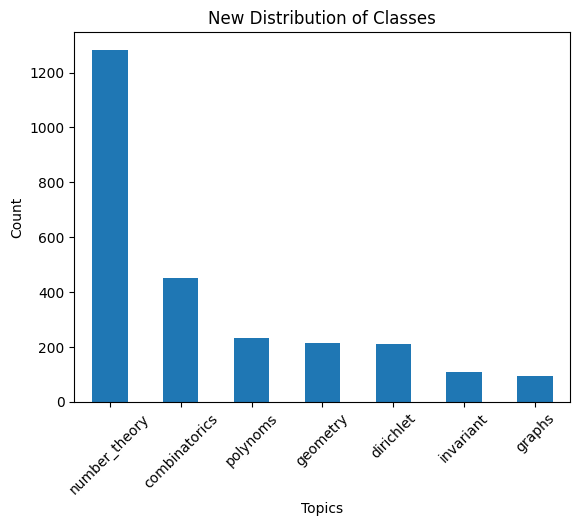

In [13]:
# Lets see how the classes are represeted in our train set
import matplotlib.pyplot as plt

class_counts = train['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [14]:
class_counts

topic
number_theory    1284
combinatorics     451
polynoms          231
geometry          212
dirichlet         211
invariant         109
graphs             93
Name: count, dtype: int64

In [15]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


In [16]:
# for Kaggle & Bert tokenizer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [17]:
!nvidia-smi

Sun May  5 22:16:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

print('ok')

ok


In [19]:
!pip uninstall tensorflow -y


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0


In [20]:
# actual augmenting happens here

import nlpaug.augmenter.word as naw
import pandas as pd
import torch
torch.set_printoptions(profile="full")

torch.set_num_threads(1) # I had to do that due to some obscure mistake


# Инициализация аугментатора BERT
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cpu')
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cuda')
# Use PyTorch as the backend
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", device='cuda', force_reload=True)

# Определение максимального количества примеров в классе
max_samples = train['topic'].value_counts().max()

# Создание пустого DataFrame для аугментированных данных
augmented_data = pd.DataFrame(columns=train.columns)

# Аугментация данных
for topic in train['topic'].unique():
    # Вычисление необходимого количества аугментаций для класса
    current_count = train[train['topic'] == topic].shape[0]
    augment_count = max_samples - current_count
    
    if augment_count > 0:
        # Выборка случайных примеров для аугментации
        sample = train[train['topic'] == topic].sample(n=augment_count, replace=True)
        
        # Применение аугментации
        sample['problem_text'] = sample['problem_text'].apply(lambda x: aug.augment(x))
        
        # Добавление аугментированных примеров в датасет
        augmented_data = pd.concat([augmented_data, sample])

# Объединение аугментированных данных с исходным обучающим датасетом
train_augmented = pd.concat([train, augmented_data])

# Перемешиваем данные
train_augmented = train_augmented.sample(frac=1).reset_index(drop=True)

# Сохраняем аугментированный датасет в новый CSV-файл
train_augmented.to_csv('train_augmented.csv', index=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
len(train_augmented)

8988

In [22]:
!ls -la /kaggle/working

total 434120
drwxr-xr-x 6 root root      4096 May  5 22:16 .
drwxr-xr-x 5 root root      4096 May  5 22:16 ..
drwxr-xr-x 2 root root      4096 May  5 22:16 .virtual_documents
drwxr-xr-x 2 root root      4096 May  5 22:15 logs
drwxr-xr-x 9 root root      4096 May  5 22:15 results
-rw-r--r-- 1 root root 440650825 May  5 22:15 state.db
-rw-r--r-- 1 root root    221816 May  5 22:16 test.csv
-rw-r--r-- 1 root root    645934 May  5 22:16 train.csv
-rw-r--r-- 1 root root   2758318 May  5 22:31 train_augmented.csv
-rw-r--r-- 1 root root    221225 May  5 22:16 val.csv
drwxr-xr-x 3 root root      4096 May  5 22:15 wandb


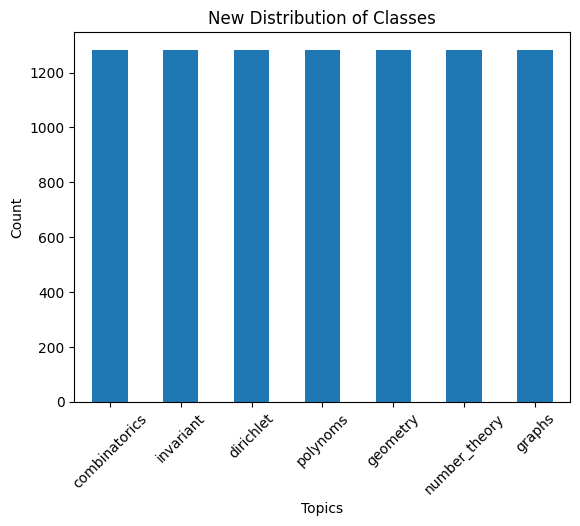

In [23]:
# Lets marvel at the augmeted train set
import matplotlib.pyplot as plt

class_counts = train_augmented['topic'].value_counts()
class_counts.plot(kind='bar')
plt.title('New Distribution of Classes')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [24]:
# There could be some duplicates creeping in after the augmetation
duplicates = train_augmented.duplicated(subset=['problem_text'], keep=False)

num_duplicates = duplicates.sum()

print(f'Количество дубликатов в столбце "problem_text": {num_duplicates}')

Количество дубликатов в столбце "problem_text": 8


In [25]:
duplicates

0       False
1       False
2       False
3       False
4       False
        ...  
8983    False
8984    False
8985    False
8986    False
8987    False
Length: 8988, dtype: bool

In [26]:
# Downloading neccessities

import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'train_augmented.csv'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

/kaggle/working/train_augmented.csv

In [27]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'val.csv'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

/kaggle/working/val.csv

In [28]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'test.csv'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

/kaggle/working/test.csv

In [29]:
train_augmented['topic'].value_counts()


topic
combinatorics    1284
invariant        1284
dirichlet        1284
polynoms         1284
geometry         1284
number_theory    1284
graphs           1284
Name: count, dtype: int64

In [30]:
!pip install transformers


In [31]:
# ЭТА ЯЧЕЙКА ВИДИМО НЕ НУЖНА!

from transformers import AutoTokenizer

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Изменённая функция токенизации
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Применяем функцию токенизации ко всему столбцу 'problem_text'
train_dataset = train_augmented['problem_text'].apply(tokenize_function)
test_dataset = test['problem_text'].apply(tokenize_function)
val_dataset = val['problem_text'].apply(tokenize_function)

# Проверяем первый элемент токенизированных данных
print(train_dataset.iloc[0])


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

{'input_ids': tensor([[  101, 12235, 10821, 10638, 12487, 22021,  4388,   128, 11664, 10037,
         10831, 10821, 41015, 16888, 10681, 10638, 12487, 22021,  4388,   120,
         10984, 11300, 42456,   239, 10626,   240, 12099, 11196,   122, 10623,
         10892, 10647,   132,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [42]:
train_augmented['problem_text']

0       There were seven boxes, some of which were fil...
1       [there is an infinite number of rooms to one w...
2       [in the table of n columns into three colors, ...
3       [on the chess board, 5x5 cells were placed 25 ...
4       [the square three - member x2 + bx + c is two ...
                              ...                        
8983    [several angles to every sphere. prove if the ...
8984    [from this decision list : < < 1 30 32 32 33 3...
8985    [only non - zero numbers e and b appear so an ...
8986    There are 20 villages on the coast of the roun...
8987    [a, b, dc > 9 and abc = 6. only is known that ...
Name: problem_text, Length: 8988, dtype: object

In [46]:
from datasets import Dataset
import pandas as pd

# Assume train_augmented, val, and test are DataFrames
# Convert the column "problem_text" to string format
train_augmented['problem_text'] = train_augmented['problem_text'].astype(str)
val['problem_text'] = val['problem_text'].astype(str)
test['problem_text'] = test['problem_text'].astype(str)

# Convert the pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_augmented)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Load the tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['problem_text'], padding="max_length", truncation=True, max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Ensure labels are included
train_dataset = train_dataset.map(lambda examples: {'labels': examples['topic']}, batched=True)
val_dataset = val_dataset.map(lambda examples: {'labels': examples['topic']}, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type='torch', columns=["input_ids", "attention_mask"])


Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

In [53]:
train_dataset['labels'][0]


'combinatorics'

In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AdamW
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers.trainer_utils import EvalPrediction
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

# Encode labels into integers
label_encoder = LabelEncoder()
train_augmented['labels'] = label_encoder.fit_transform(train_augmented['topic'])
val['labels'] = label_encoder.transform(val['topic'])
test['labels'] = label_encoder.transform(test['topic'])

# Convert the DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_augmented)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['problem_text'], padding="max_length", truncation=True, max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type='torch', columns=["input_ids", "attention_mask", "labels"])

# Check first element
print(train_dataset[0])

# Define the number of classes
num_labels = len(label_encoder.classes_)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=num_labels)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Define the compute metrics function
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = torch.argmax(logits, dim=-1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Change the output directory to have more space
output_dir = './results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Try different learning rates
best_f1 = 0
best_lr = 0
best_trainer = None
for lr in [1e-5, 2e-5, 3e-5]:
    print(f"Training with learning rate: {lr}")
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        save_steps=5000,
        save_total_limit=2,
        learning_rate=lr,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        optimizers=(AdamW(model.parameters(), lr=lr), None),
        compute_metrics=compute_metrics
    )
    
    trainer.train()
    evaluation = trainer.evaluate()
    f1 = evaluation.get('eval_f1', 0)

    if f1 > best_f1:
        best_f1 = f1
        best_lr = lr
        best_trainer = trainer

print(f"Best learning rate: {best_lr} with F1 Score: {best_f1}")

# Use the best trainer for predictions
predictions = best_trainer.predict(val_dataset)
true_labels = predictions.label_ids
predicted_labels = predictions.predictions.argmax(axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [ ]:
print('ok')